# Joint histograms of cold point temp and brightness temperature for the DYAMOND2 models
Saves the histogram pickle files if they're not already made and makes the plots (just individual for now)

In [1]:
import pickle
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import biv_hist_d2 as bhd
import biv_hist as biv
import get_d2_data as get_d2

from matplotlib import cm
from matplotlib.gridspec import GridSpec


In [2]:
file_path = "/work/bb1153/b380887/10x10/"
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/d2_tb-cpt_hists/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/tb-cpT_hists/"


## Make or read in the dictionary files

### Get the histogram pickle files, one model at a time
Skip if these are made already.

In [3]:
model = "OBS"
# region_list = ["AMZ", "SPC"] #, "TIM", "SCA"]
region_list = ["TIM", "SCA"]


##### Models:

In [4]:
%%time
for region in region_list:
    cpT = get_d2.get_cold_point(region, model, file_path)
    tb = get_d2.get_brightness_temp(region, model, file_path)
    tb_count = tb.count().values

    dict_file_name = "{m}_Tb-cpT_hist_dict_{r}.pickle".format(m=model, r=region)
    hist_dict = bhd.compute_histogram(model, cpT, tb, tb_count)
        
    with open(pickle_dir + dict_file_name, "wb") as handle:
        pickle.dump(hist_dict, handle)

    print("Dictionary saved to " + pickle_dir + dict_file_name)


UnboundLocalError: local variable 'cpT' referenced before assignment

##### Obs:

In [4]:
year_list = [2007, 2008, 2009, 2010]

In [6]:
hist_dict_obs = {}

for region in region_list:
    hist_computed_list = [[]]*len(year_list)
    nan_len_list = [[]]*len(year_list)

    for i, year in enumerate(year_list):
        with open(pickle_dir + "obs/Tb-cpT_hist_dict_DJF{y}_{r}.pickle".format(y=year, r=region), "rb") as handle:
            hist_dict_yr = pickle.load(handle)
        hist_computed_list[i] = hist_dict_yr["hist_computed"]
        nan_len_list[i] = hist_dict_yr["nan_len"]

    # sum across years
    nan_len = sum(nan_len_list)
    hist_computed = np.sum(hist_computed_list, axis=0)

    # take bins & edges from the last dict in list
    hist_dict = {
        "hist_computed": hist_computed, 
        "xedges": hist_dict_yr["xedges"], 
        "yedges": hist_dict_yr["yedges"], 
        "tb_bins": hist_dict_yr["tb_bins"], 
        "cpT_bins": hist_dict_yr["cpT_bins"],
        "nan_len": nan_len,
    }

    hist_dict_obs[region] = hist_dict


### Read in the dictionaries (for models)

In [7]:
model_list = ["SCREAM", "SHIELD", "GEOS", "ICON", "SAM"]
# region_list = ["AMZ", "SPC"] #, "TIM", "SCA"]
region_list = ["TIM", "SCA"]


In [8]:
hist_dict_models = {}

for model in model_list:
    region_dict = {}
    
    for region in region_list:
        dict_file_name = "{m}_Tb-cpT_hist_dict_{r}.pickle".format(m=model, r=region)
        with open(pickle_dir + dict_file_name, "rb") as handle:
            region_dict[region] = pickle.load(handle)
            
    hist_dict_models[model] = region_dict
    

In [10]:
# list(hist_dict_models["GEOS"]["SPC"].keys())

In [11]:
list(hist_dict_models["GEOS"]["SCA"].keys())

['hist_computed', 'xedges', 'yedges', 'tb_bins', 'cpT_bins', 'nan_len']

In [20]:
hist = hist_dict_models["GEOS"]["SPC"]["hist_computed"]
tb_bins = hist_dict_models["GEOS"]["SPC"]["yedges"]
cpT_bins = hist_dict_models["GEOS"]["SPC"]["xedges"]


In [12]:
hist = hist_dict_models["GEOS"]["SCA"]["hist_computed"]
tb_bins = hist_dict_models["GEOS"]["SCA"]["yedges"]
cpT_bins = hist_dict_models["GEOS"]["SCA"]["xedges"]


## Plots


In [13]:
def plot_joint_hist(ax, hist_dict, fsize, labsize, colormap=cm.gist_earth_r,
               levels=np.arange(-6, -1), gridlines=True, show_colorbar=True,
                   ylabel=True, xlabel=True):
    """ 
    Plot joint brightness temperature-cold point histogram for a single region.
    """
    nan_len = hist_dict["nan_len"]
    hist_computed = hist_dict["hist_computed"]
    xedges = hist_dict["xedges"]
    yedges = hist_dict["yedges"]
    tb_bins = hist_dict["tb_bins"]
    cpT_bins = hist_dict["cpT_bins"]

    hist_normed = hist_computed/nan_len # normalized bin count
    xbin_means, ybin_means = (xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2
    hist_normed_nonzero = np.where(hist_normed > 0, hist_normed, np.nan)

    if gridlines:
        ax.grid(linestyle=":", color="gray")

    if levels is None:
        csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both',
                         cmap=colormap)
    else:
        csn = ax.contourf(xbin_means, ybin_means, np.log10(hist_normed_nonzero.T), extend='both', levels=levels, 
                          vmin=levels[0], vmax=levels[-1], cmap=colormap)
    ax.contour(csn, colors='k', linestyles='solid', linewidths=1) # to add the black lines to outline the contours
    
    if show_colorbar:
        cb = plt.colorbar(csn, ax=ax)
        cb.set_label("log$_{10}$(PDF)", fontsize=fsize-1)
        cb.ax.tick_params(axis="y", labelsize=labsize)
        
    if xlabel:
        ax.set_xlabel("$T_{CP}$ (K)", fontsize=fsize)
    if ylabel:
        ax.set_ylabel("$T_b$ (K)", fontsize=fsize)
    ax.tick_params(axis="both", labelsize=labsize)
    ax.set_ylim((tb_bins[0], tb_bins[-1]))
    ax.set_xlim((cpT_bins[0], cpT_bins[-1]))
    
    # Tb=Tcp line
    ax.plot(cpT_bins, cpT_bins, color="k", linewidth=2)
    
    return csn


In [14]:
def plot_single_panel(hist_dict, model, region, ymax=280,
                      figsize=(8, 4), fsize=27, tsize=35, labsize=20, save=False):
    """ Plot single panel of just the tb-cpT histogram
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    plot_joint_hist(ax, hist_dict, fsize, labsize, colormap=cm.gist_earth_r,
                    levels=np.arange(-6, -1), gridlines=True, show_colorbar=True)
    ax.set_title("{m} ({r})".format(m=model, r=region), fontsize=tsize)
    ax.set_ylim(top=ymax)
    
    if save:
        plt.savefig(save_dir + "{m}_joint_hist_{r}.png".format(m=model, r=region), dpi=300, bbox_inches="tight")
        
    plt.show()
    

### All together

In [15]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "OBS": "Obs. (DJF 2007-2010)"
}

In [16]:
def plot_all_panels(hist_dict_all, model_list, region, title_dict, ymax=280,
                      figsize=(24, 9), fsize=27, tsize=28, labsize=20, save=False):
    """ Plot all panels of the tb-cpT histograms
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(4, 6, height_ratios=[0.075, 1, 1, 0.15], hspace=0.75, wspace=0.5)
    ax_title = plt.subplot(gs[0, 1:5])
    ax_list = [
        plt.subplot(gs[1, :2]),
        plt.subplot(gs[1, 2:4]),
        plt.subplot(gs[1, 4:]),
        plt.subplot(gs[2, :2]),
        plt.subplot(gs[2, 2:4]),
        plt.subplot(gs[2, 4:]),
    ]
    ax_cb = plt.subplot(gs[3, 1:5])
    
    for i, model in enumerate(model_list):
        ax = ax_list[i]
        hist_dict = hist_dict_all[model][region]
        if i in [0, 3]:
            ylab = True
        else:
            ylab = False
        if i in [0, 1, 2]:
            xlab = False
        else:
            xlab = True
        csn = plot_joint_hist(ax, hist_dict, fsize, labsize, colormap=cm.gist_earth_r,
                        levels=np.arange(-6, -1), gridlines=True, show_colorbar=False,
                             ylabel=ylab, xlabel=xlab)
        ax.set_title(title_dict[model], fontsize=tsize)
        ax.set_ylim(top=ymax)
        
    # colorbar
    cbar = plt.colorbar(csn, cax=ax_cb, orientation="horizontal") 
    cbar.set_label("log$_{10}$(PDF)", fontsize=fsize-1)
    cbar.ax.tick_params(axis="x", labelsize=labsize)
    
    # title
    ax_title.axis("off")
    ax_title.text(x=0.5, y=0, s=region, verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )
    if save:
        inits = ""
        for model in model_list:
            inits += model[0]
        plt.savefig(save_dir + "{i}_joint_hist_{r}.png".format(i=inits, r=region), dpi=300, bbox_inches="tight")
        
    plt.show()
    

In [17]:
# add obs to the model dict so it's all in one
hist_dict_models["OBS"] = hist_dict_obs


In [18]:
save_dir

'/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/tb-cpT_hists/'

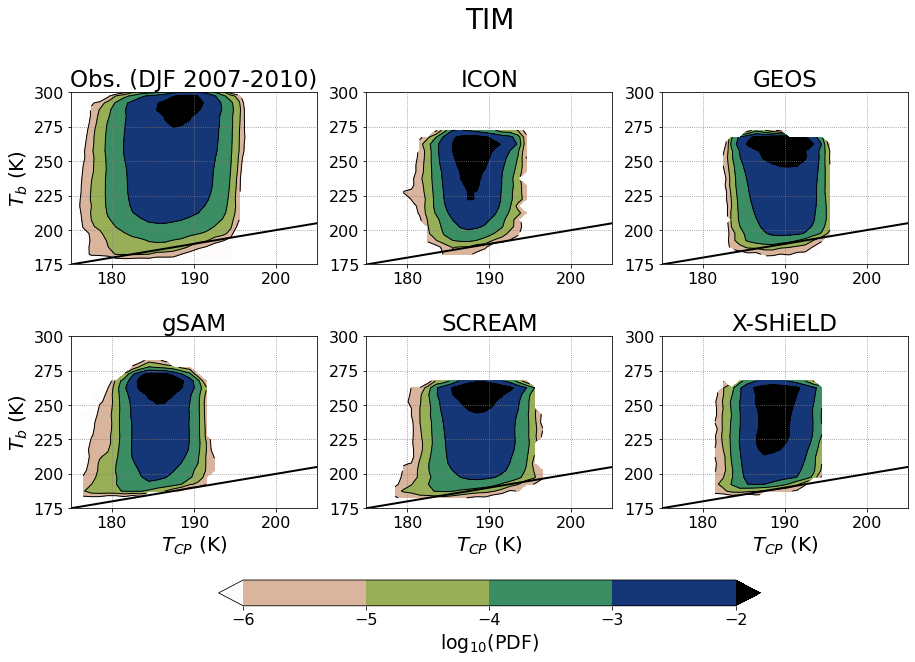

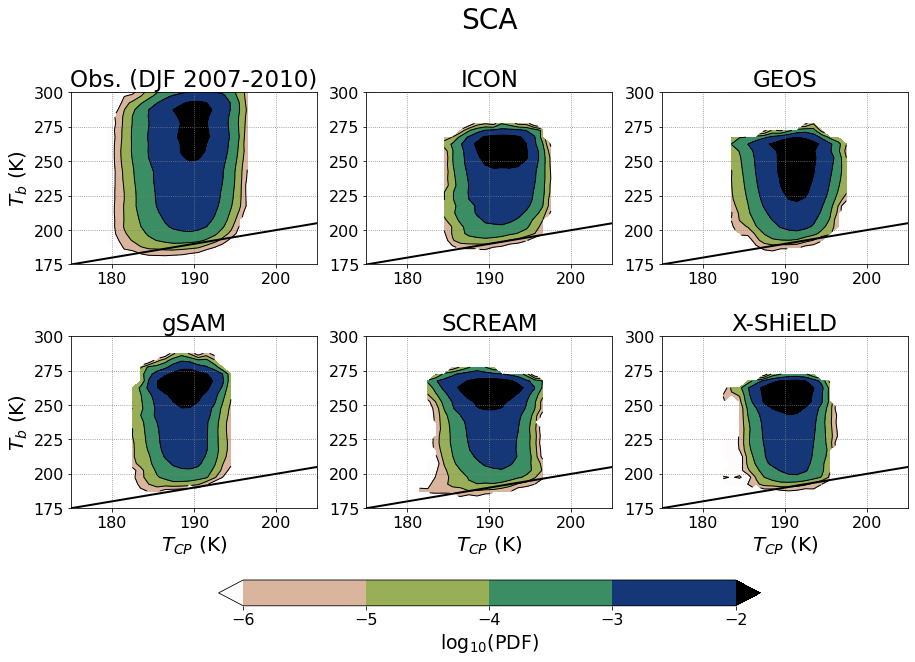

In [19]:
plot_model_list = ["OBS", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]

for region in ["TIM", "SCA"]:
    plot_all_panels(hist_dict_models, plot_model_list, region, title_dict,
                    ymax=300, tsize=23, fsize=20, labsize=16, figsize=(15, 11), 
                    save=True)


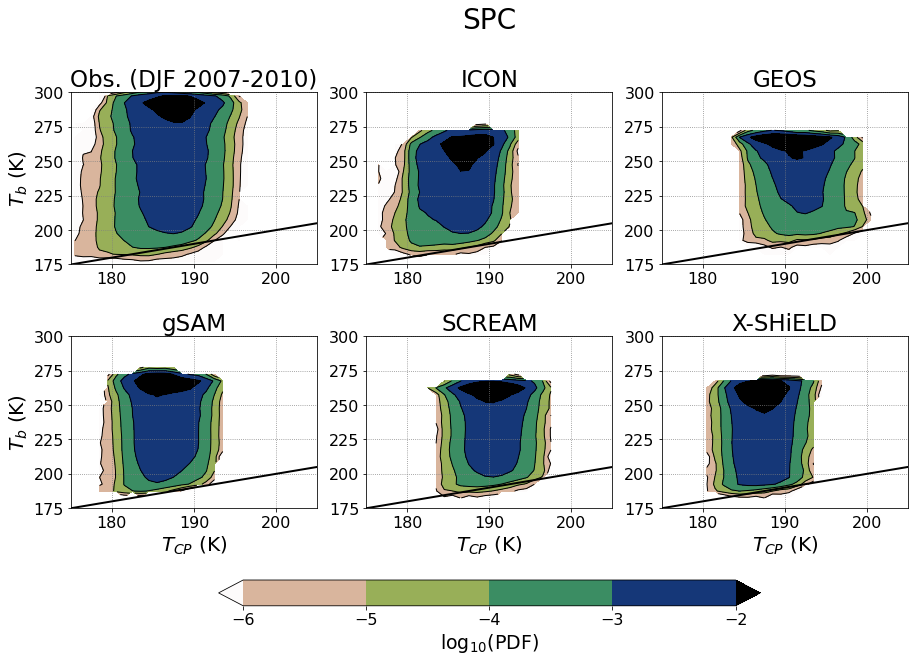

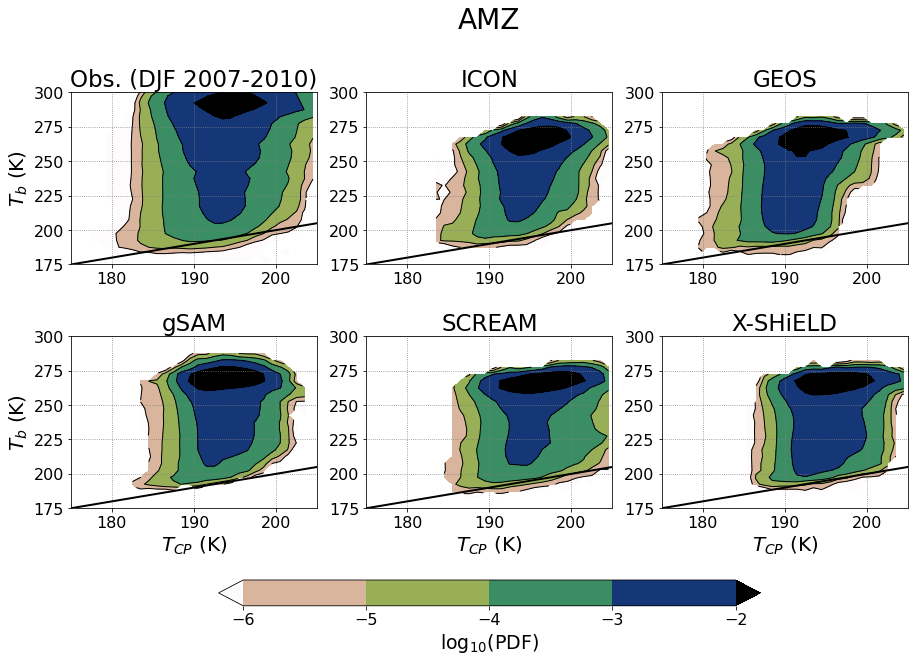

In [106]:
plot_model_list = ["OBS", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]

for region in ["SPC", "AMZ"]:
    plot_all_panels(hist_dict_models, plot_model_list, region, title_dict,
                    ymax=300, tsize=23, fsize=20, labsize=16, figsize=(15, 11), 
                    save=True)


### Single panels

In [43]:
def plot_single_panel(hist_dict, model, region, ymax=280,
                      figsize=(8, 4), fsize=27, tsize=35, labsize=20, save=False):
    """ Plot single panel of just the tb-cpT histogram
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    plot_joint_hist(ax, hist_dict, fsize, labsize, colormap=cm.gist_earth_r,
                    levels=np.arange(-6, -1), gridlines=True, show_colorbar=True)
    ax.set_title("{m} ({r})".format(m=model, r=region), fontsize=tsize)
    ax.set_ylim(top=ymax)
    
    if save:
        plt.savefig(save_dir + "{m}_joint_hist_{r}.png".format(m=model, r=region), dpi=300, bbox_inches="tight")
        
    plt.show()
    

#### Obs, all regions

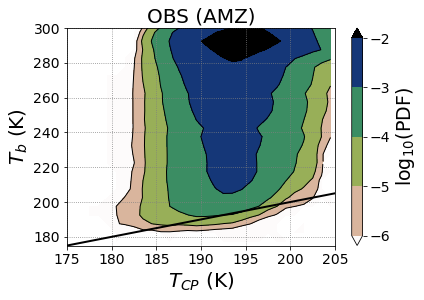

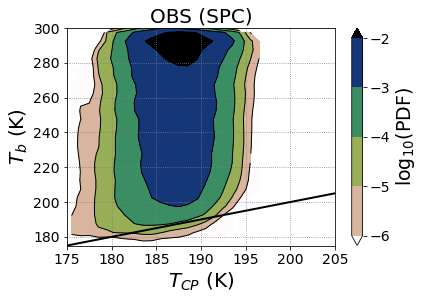

In [16]:
for region in list(hist_dict_obs.keys()):
    plot_single_panel(hist_dict_obs[region], "OBS", region, ymax=300,
                         tsize=20, fsize=20, labsize=14, figsize=(6, 4), save=True)


#### Models, all regions

In [9]:
model_list = ["SHIELD", "SCREAM", "GEOS", "ICON", "SAM"]


#### TIM

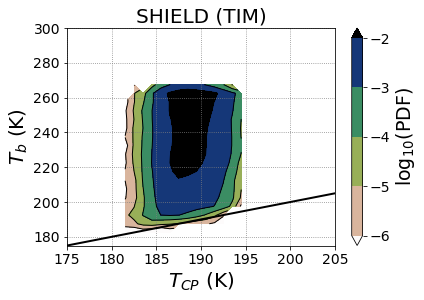

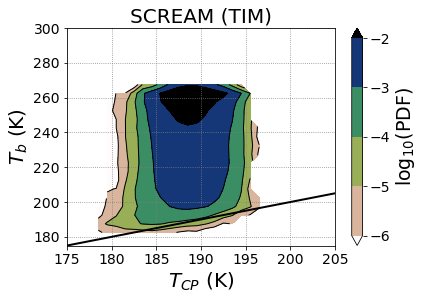

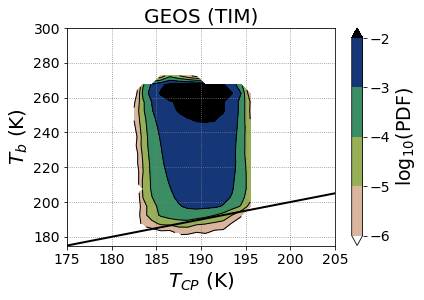

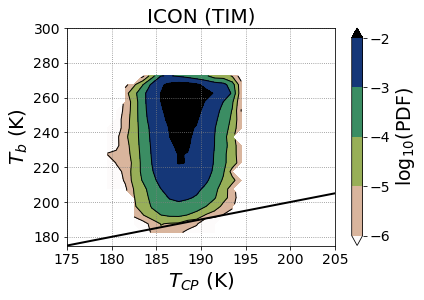

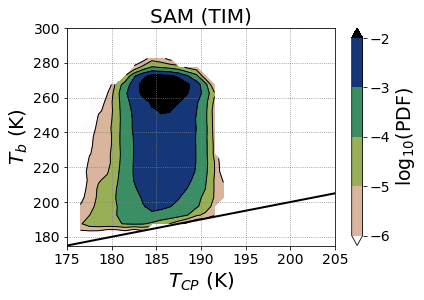

In [12]:
for model in model_list:
    plot_single_panel(hist_dict_models[model]["TIM"], model, "TIM", ymax=300,
                     tsize=20, fsize=20, labsize=14, figsize=(6, 4), save=True)


#### SCA

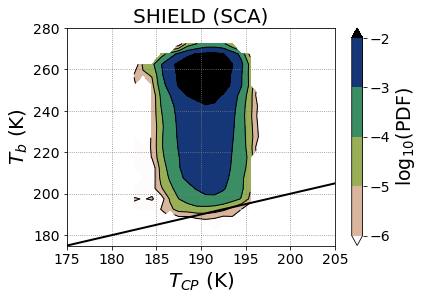

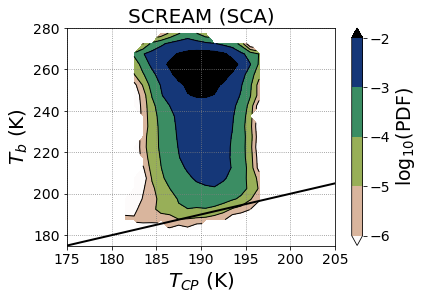

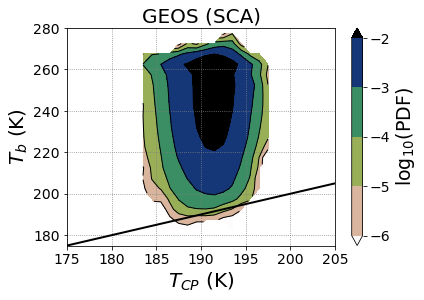

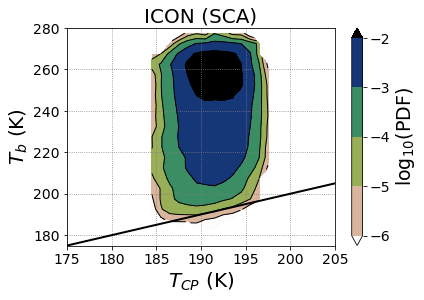

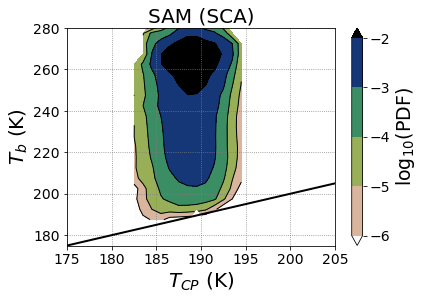

In [11]:
for model in model_list:
    plot_single_panel(hist_dict_models[model]["SCA"], model, "SCA", ymax=280,
                     tsize=20, fsize=20, labsize=14, figsize=(6, 4), save=True)


#### AMZ


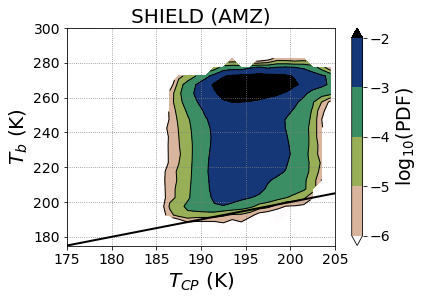

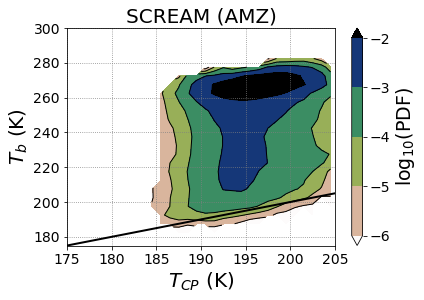

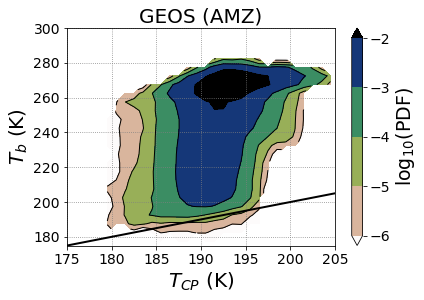

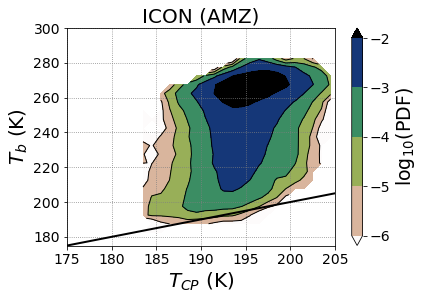

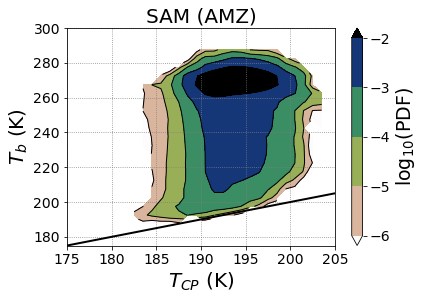

In [16]:
for model in model_list:
    plot_single_panel(hist_dict_models[model]["AMZ"], model, "AMZ", ymax=300,
                     tsize=20, fsize=20, labsize=14, figsize=(6, 4), save=True)


#### SPC


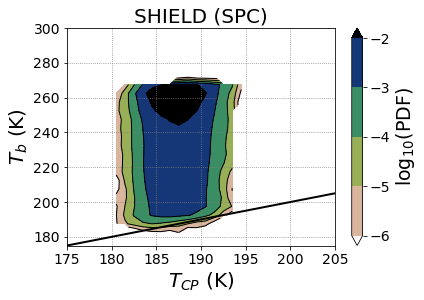

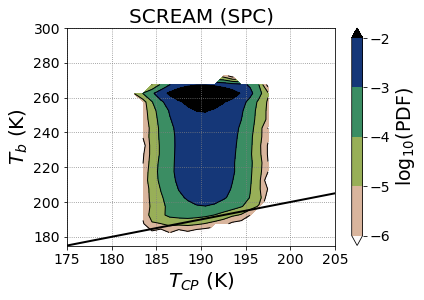

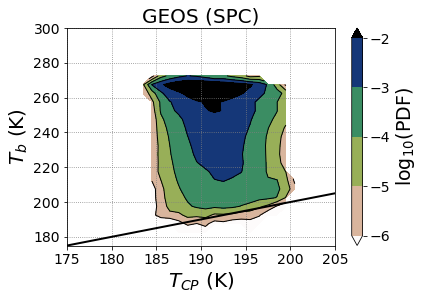

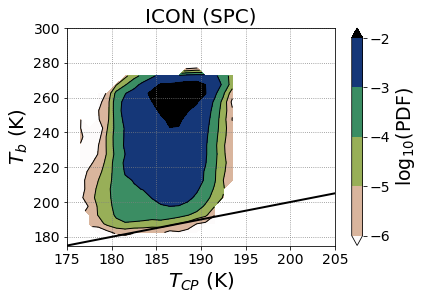

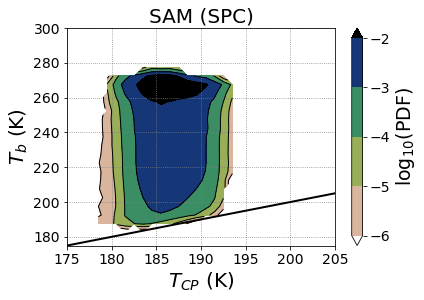

In [17]:
for model in model_list:
    plot_single_panel(hist_dict_models[model]["SPC"], model, "SPC", ymax=300,
                     tsize=20, fsize=20, labsize=14, figsize=(6, 4), save=True)
